In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

products = {
    "crypto": [
        "BTC-USD",
        "ETH-USD",
        "SOL-USD",
        "XRP-USD",
        "ADA-USD",
        "DOGE-USD",
        "AVAX-USD",
        "LINK-USD",
        "DOT-USD",
        "MATIC-USD",
    ],
    # "crypto":  ["BTC-USD", "ETH-USD"],
}

In [2]:
def get_df_crypto_fear_greed_index():
    print("Retrieving historical crypto fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_etf_fear_greed_index():
    print("Retrieving historical ETF fear and greed index")
    import json

    with open("cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id, product_type):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="3y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_fear_greed_index = df_crypto_fear_greed_index if product_type == "crypto" else df_etf_fear_greed_index
    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]], how="inner")
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            )
            df_history[f"{column}_gradient_max_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            )

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            {"kind": "sma", "length": get_strategy_length(10)},
            {"kind": "sma", "length": get_strategy_length(20)},
            {"kind": "sma", "length": get_strategy_length(50)},
            {"kind": "bbands", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(14)},
            {
                "kind": "macd",
                "fast": get_strategy_length(8),
                "slow": get_strategy_length(21),
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(10),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(20),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(50),
                "prefix": "VOLUME",
            },
        ],
    )
    df_history.ta.strategy(CustomStrategy)

    return df_history


df_crypto_fear_greed_index = get_df_crypto_fear_greed_index()
df_etf_fear_greed_index = get_df_etf_fear_greed_index()

history_dfs = {}
product_ids = []

for product_type in products.keys():
    for product_id in products[product_type]:
        product_ids.append(product_id)
        history_dfs[product_id] = get_df_history(product_id, product_type=product_type)
        history_dfs[product_id]["product_id"] = product_id
        history_dfs[product_id]["product_type"] = product_type

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for product_id in product_ids:
    df_final_product = df_final.loc[df_final.product_id == product_id]
    # df_final = df_final.loc[(df_final.index >= df_final_product.index.min()) & (df_final.index <= df_final_product.index.max())]
    # df_final = df_final.loc[df_final.index.isin(df_final_product.index)]

df_final

Retrieving historical crypto fear and greed index
Retrieving historical ETF fear and greed index
Retrieving historical data for BTC-USD
Retrieving historical data for ETH-USD
Retrieving historical data for SOL-USD
Retrieving historical data for XRP-USD
Retrieving historical data for ADA-USD
Retrieving historical data for DOGE-USD
Retrieving historical data for AVAX-USD
Retrieving historical data for LINK-USD
Retrieving historical data for DOT-USD
Retrieving historical data for MATIC-USD


,open,high,low,close,volume,dividends,stock splits,fear_greed_index,close_previous,close_min_7,close_max_7,close_gradient_7,close_gradient_min_7,close_gradient_max_7,close_min_14,close_max_14,close_gradient_14,close_gradient_min_14,close_gradient_max_14,close_min_30,close_max_30,close_gradient_30,close_gradient_min_30,close_gradient_max_30,close_min_60,close_max_60,close_gradient_60,close_gradient_min_60,close_gradient_max_60,close_min_90,close_max_90,close_gradient_90,close_gradient_min_90,close_gradient_max_90,close_min_120,close_max_120,close_gradient_120,close_gradient_min_120,close_gradient_max_120,fear_greed_index_previous,fear_greed_index_min_7,fear_greed_index_max_7,fear_greed_index_gradient_7,fear_greed_index_gradient_min_7,fear_greed_index_gradient_max_7,fear_greed_index_min_14,fear_greed_index_max_14,fear_greed_index_gradient_14,fear_greed_index_gradient_min_14,fear_greed_index_gradient_max_14,fear_greed_index_min_30,fear_greed_index_max_30,fear_greed_index_gradient_30,fear_greed_index_gradient_min_30,fear_greed_index_gradient_max_30,fear_greed_index_min_60,fear_greed_index_max_60,fear_greed_index_gradient_60,fear_greed_index_gradient_min_60,fear_greed_index_gradient_max_60,fear_greed_index_min_90,fear_greed_index_max_90,fear_greed_index_gradient_90,fear_greed_index_gradient_min_90,fear_greed_index_gradient_max_90,fear_greed_index_min_120,fear_greed_index_max_120,fear_greed_index_gradient_120,fear_greed_index_gradient_min_120,fear_greed_index_gradient_max_120,SMA_10,SMA_20,SMA_50,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_10,VOLUME_SMA_20,VOLUME_SMA_50,product_id,product_type
2021-01-22 00:00:00+00:00,30817.625000,33811.851562,28953.373047,33005.761719,77207272511,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTC-USD,crypto
2021-01-22 00:00:00+00:00,15.931008,17.983864,14.891926,17.161442,2991599976,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOT-USD,crypto
2021-01-22 00:00:00+00:00,18.412506,22.426802,17.384539,21.629498,4292258678,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINK-USD,crypto
2021-01-22 00:00:00+00:00,11.301277,13.380753,10.720327,12.718836,190313148,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AVAX-USD,crypto
2021-01-22 00:00:00+00:00,0.008165,0.008769,0.007654,0.008524,185490003,0.0,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOGE-USD,crypto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Total fee percentage: 0%
Start money: $1000
Min buy amount: $2
Max buy amount: $100
End money: $1811.45
Pct earned: 81.145%
Total orders: 6224
Avg pct earned per order: 0.013%
Total volume: $67727.68
Total days: 1093.0
Avg 30 day volume: $1858.95


,product_id,side,amount,products,value,money,total_balance
timestamp,,,,,,,
2021-02-05 00:00:00+00:00,DOGE-USD,buy,10.0,213.06061789895054,0.04693499952554703,990.0,1000.0
2021-02-05 00:00:00+00:00,SOL-USD,buy,9.9,1.4816544731013885,6.681719779968262,980.1,1000.0
2021-02-05 00:00:00+00:00,XRP-USD,buy,9.8,21.77550410828477,0.45004698634147644,970.3000000000001,1000.0
2021-02-05 00:00:00+00:00,DOT-USD,buy,9.7,0.46405542392377713,20.90267562866211,960.6,1000.0
2021-02-05 00:00:00+00:00,ADA-USD,buy,9.6,17.8480467480819,0.5378739833831787,951.0,1000.0
...,...,...,...,...,...,...,...
2024-01-19 00:00:00+00:00,LINK-USD,buy,16.41,1.0229839464035912,16.04130744934082,1625.0288788231662,1813.2562373760588
2024-01-19 00:00:00+00:00,ETH-USD,buy,16.25,0.006527418984394016,2489.49853515625,1608.7788788231662,1813.2562373760588
2024-01-20 00:00:00+00:00,LINK-USD,buy,16.08,1.0214468666984469,15.742375373840332,1592.6988788231663,1811.4463920997866


,product_id,side,total_orders
0,BTC-USD,buy,618
1,BTC-USD,sell,40
2,ETH-USD,buy,620
3,ETH-USD,sell,50
4,SOL-USD,buy,613
5,SOL-USD,sell,52
6,XRP-USD,buy,563
7,XRP-USD,sell,65
8,ADA-USD,buy,522
9,ADA-USD,sell,49


<Axes: xlabel='timestamp'>

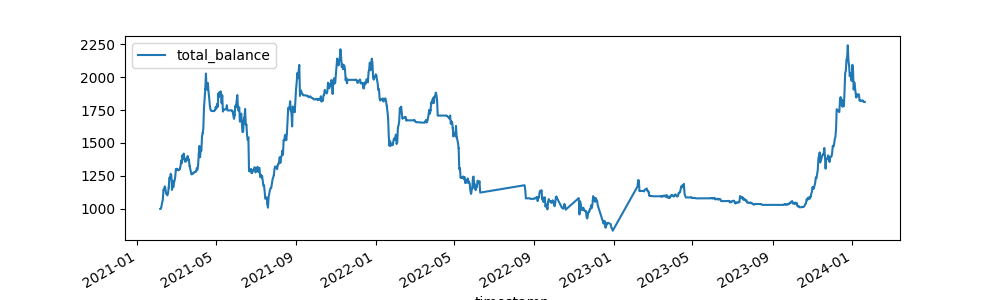

In [6]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

purchased_products = {}
total_products = len(product_ids)

for product_id in product_ids:
    purchased_products[product_id] = 0

money = 1000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 2
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []


def get_total_balance():
    total_balance = money

    for product_product_id in product_ids:
        df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == product_product_id)]

        if len(df_final_product_period) > 0:
            total_balance += purchased_products[product_product_id] * df_final_product_period.close.values[-1] * p_keep

    return total_balance


def floor_value(x: float, precision: int):
    return np.true_divide(np.floor(x * 10**precision), 10**precision)


def buy_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        # buy_amount = floor_value(money / total_products / 10, 2)
        buy_amount = floor_value(money / len(products[product_data["product_type"]]) / 10, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_products = buy_amount / product_data["close"] * p_keep
            purchased_products[product_id] += buy_products
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "products": buy_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


def sell_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        sell_products = floor_value(purchased_products[product_id], 8)
        sell_amount = sell_products * product_data["close"] * p_keep

        if sell_amount > 0:
            purchased_products[product_id] -= sell_products
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "products": sell_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


for index, row in df_final.iterrows():
    if row.product_type == "crypto" and row.fear_greed_index > 60:
        # for etf_product_id in products["stock"]:
        #     sell_product(etf_product_id)

        buy_product(row.product_id)
    elif row.product_type == "stock" and (
        row.RSI_14 > row.fear_greed_index_max_14 or (row.RSI_14 > 50 and row.fear_greed_index > 50)
    ):
        # for crypto_product_id in products["crypto"]:
        #     sell_product(crypto_product_id)

        buy_product(row.product_id)
    else:
        sell_product(row.product_id)

money += sum(
    [
        (purchased_products[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money) / start_money * 100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({"product_id": product_id, "side": side, "total_orders": len(df_orders_product_side)})

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))

In [4]:
# display(df_orders.loc[df_orders.side == "buy"].describe())
# display(df_orders.loc[df_orders.side == "sell"].describe())

In [5]:
# df_final.loc[df_final.product_id == "VGT"][:100][["product_type", "close", "fear_greed_index", "fear_greed_index_max_14", "RSI_14"]]